## PyTorch Datasets and DataLoaders

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [4]:
!pip install torch torchvision
#!pip install transform
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations for training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.RandomCrop(32, padding=4),  # 随机裁剪图像，并在周围填充0
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define data transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes = [
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified
Files already downloaded and verified
Num training examples: 50000
Num test examples: 10000


In [2]:
# Fetch one batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Inspect the shapes and value ranges of images (X) and labels (Y)
images_shape = images.shape
images_dtype = images.dtype
images_min = images.min().item()
images_max = images.max().item()

labels_shape = labels.shape
labels_dtype = labels.dtype

images_shape, images_dtype, images_min, images_max, labels_shape, labels_dtype

(torch.Size([64, 3, 32, 32]),
 torch.float32,
 -1.0,
 1.0,
 torch.Size([64]),
 torch.int64)

## Visualizing Examples from the CIFAR10 Dataset

Note: you may need to restart the kernel to use updated packages.


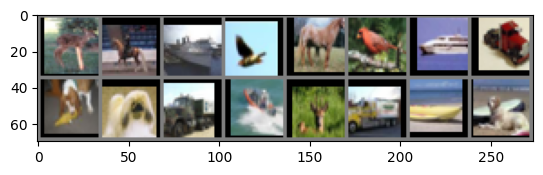

deer -- horse -- ship -- bird -- horse -- bird -- ship -- truck
dog -- dog -- truck -- ship -- deer -- truck -- ship -- dog


In [3]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

## Training on the GPU and Evaluating Performance
Calculate train and test accuracy

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the neural network
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

        # Initialize weights of self.linear with a small random number from a normal distribution
        #nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
        #nn.init.normal_(self.linear2.weight, mean=0.0, std=0.01)
        nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # 將x展平以匹配全連接層的期望輸入形狀
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


### Epoch Bound(EB)

In [12]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = TwoLayerNet(3*32*32, 1000, 10)# CIFAR10: 3 color channels, 32x32 pixels
print(net)

# Move the model to the GPU if available
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001) #weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。

# Train the neural network
num_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

for epoch in range(num_epochs):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(inputs.shape, inputs)
        #print(labels.shape, labels)
        #print(outputs.shape, outputs)
        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 更新学习率
    scheduler.step()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    print(f"Epoch: {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")


    # let's evaluate its performance on the test dataset.
    net.eval()
    # Test the neural network
    correct = 0
    total = 0
    test_loss = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            #print(inputs.size(), labels.size())

            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(inputs)

            # Calculate test loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
            
            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples and correct predictions
            total += labels.size(0)
    
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失
    avg_test_loss = test_loss / len(test_loader.dataset)
    # Calculate the accuracy
    test_accuracy = 100 * correct / total
    print(f"Epoch: {epoch + 1}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Using device: cpu
TwoLayerNet(
  (linear1): Linear(in_features=3072, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
)
Epoch: 1, Train Loss: 1.9362, Train Accuracy: 33.60%
Epoch: 1, Test Loss: 2.3259, Test Accuracy: 35.34%
Epoch: 2, Train Loss: 1.7177, Train Accuracy: 39.00%
Epoch: 2, Test Loss: 1.7571, Test Accuracy: 41.40%
Epoch: 3, Train Loss: 1.6672, Train Accuracy: 40.45%
Epoch: 3, Test Loss: 1.8437, Test Accuracy: 39.65%
Epoch: 4, Train Loss: 1.6500, Train Accuracy: 41.11%
Epoch: 4, Test Loss: 1.7233, Test Accuracy: 41.11%
Epoch: 5, Train Loss: 1.6259, Train Accuracy: 42.00%
Epoch: 5, Test Loss: 1.7685, Test Accuracy: 40.96%
Epoch: 6, Train Loss: 1.6148, Train Accuracy: 42.44%
Epoch: 6, Test Loss: 1.8066, Test Accuracy: 40.33%
Epoch: 7, Train Loss: 1.5971, Train Accuracy: 42.87%
Epoch: 7, Test Loss: 1.9980, Test Accuracy: 39.15%
Epoch: 8, Train Loss: 1.5880, Train Accuracy: 43.26%
Epoch: 8, Test Loss: 1.6818, Test Accuracy: 41.92%
E

### Learning Goal(LG)

In [16]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = TwoLayerNet(3*32*32, 1000, 10)# CIFAR10: 3 color channels, 32x32 pixels
print(net)

# Move the model to the GPU if available
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001) #weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

epsilon = 1.50
epoch = 0
while True:
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(inputs.shape, inputs)
        #print(labels.shape, labels)
        #print(outputs.shape, outputs)
        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 更新学习率
    scheduler.step()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total

    # let's evaluate its performance on the test dataset.
    net.eval()
    # Test the neural network
    correct = 0
    total = 0
    test_loss = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            #print(inputs.size(), labels.size())

            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(inputs)

            # Calculate test loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
            
            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples and correct predictions
            total += labels.size(0)
    
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失
    avg_test_loss = test_loss / len(test_loader.dataset)
    # Calculate the accuracy
    test_accuracy = 100 * correct / total
    print(f"Epoch: {epoch + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")

    if avg_train_loss < epsilon:
        print(f"Stopping training as the average loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN yes~")
        break
    epoch += 1

Using device: cpu
TwoLayerNet(
  (linear1): Linear(in_features=3072, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
)
Epoch: 1, TrainLoss: 1.9423, TrainAccuracy: 33.98%, TestLoss: 1.9244, TestAccuracy: 38.61%
Epoch: 2, TrainLoss: 1.7124, TrainAccuracy: 39.40%, TestLoss: 1.9861, TestAccuracy: 37.64%
Epoch: 3, TrainLoss: 1.6550, TrainAccuracy: 40.62%, TestLoss: 1.8289, TestAccuracy: 39.45%
Epoch: 4, TrainLoss: 1.6248, TrainAccuracy: 42.06%, TestLoss: 1.7057, TestAccuracy: 41.86%
Epoch: 5, TrainLoss: 1.5883, TrainAccuracy: 43.01%, TestLoss: 1.7474, TestAccuracy: 41.15%
Epoch: 6, TrainLoss: 1.5538, TrainAccuracy: 44.42%, TestLoss: 1.5852, TestAccuracy: 43.46%
Epoch: 7, TrainLoss: 1.5181, TrainAccuracy: 45.79%, TestLoss: 1.5370, TestAccuracy: 45.24%
Epoch: 8, TrainLoss: 1.4882, TrainAccuracy: 47.03%, TestLoss: 1.4682, TestAccuracy: 48.48%
Stopping training as the average loss 1.4882 is less than epsilon 1.5, acceptable 2LNN yes~


### Epoch Bound(EB) + Learning Goal(LG)

In [15]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = TwoLayerNet(3*32*32, 1000, 10)# CIFAR10: 3 color channels, 32x32 pixels
print(net)

# Move the model to the GPU if available
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001) #weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。

epsilon = 1.50
num_epochs = 10
epoch = 0

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
while True:
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)


        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        #print(inputs.shape, inputs)
        #print(labels.shape, labels)
        #print(outputs.shape, outputs)
        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 更新学习率
    scheduler.step()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total

    # let's evaluate its performance on the test dataset.
    net.eval()
    # Test the neural network
    correct = 0
    total = 0
    test_loss = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            #print(inputs.size(), labels.size())

            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(inputs)

            # Calculate test loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
            
            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples and correct predictions
            total += labels.size(0)
    
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失
    avg_test_loss = test_loss / len(test_loader.dataset)
    # Calculate the accuracy
    test_accuracy = 100 * correct / total
    print(f"Epoch: {epoch + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")

    if avg_train_loss < epsilon:
        print(f"Stopping training as the average loss {avg_train_loss:.4f} is less than epsilon {epsilon}, acceptable 2LNN yes~")
        break
    epoch += 1

    if epoch >= num_epochs:
        print(f"Stopping training as the epoch {epoch} is greater than {num_epochs} epochs, unacceptable 2LNN ohoh...")
        break


Using device: cpu
TwoLayerNet(
  (linear1): Linear(in_features=3072, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
)
Epoch: 1, TrainLoss: 1.9364, TrainAccuracy: 33.88%, TestLoss: 2.0519, TestAccuracy: 37.63%
Epoch: 2, TrainLoss: 1.7198, TrainAccuracy: 39.06%, TestLoss: 1.9089, TestAccuracy: 37.77%
Epoch: 3, TrainLoss: 1.6577, TrainAccuracy: 40.76%, TestLoss: 1.6989, TestAccuracy: 40.77%
Epoch: 4, TrainLoss: 1.6192, TrainAccuracy: 42.00%, TestLoss: 1.7427, TestAccuracy: 41.67%
Epoch: 5, TrainLoss: 1.5830, TrainAccuracy: 43.29%, TestLoss: 1.6585, TestAccuracy: 42.96%
Epoch: 6, TrainLoss: 1.5567, TrainAccuracy: 44.63%, TestLoss: 1.6357, TestAccuracy: 43.83%
Epoch: 7, TrainLoss: 1.5145, TrainAccuracy: 45.85%, TestLoss: 1.5560, TestAccuracy: 45.21%
Epoch: 8, TrainLoss: 1.4849, TrainAccuracy: 47.33%, TestLoss: 1.4734, TestAccuracy: 48.08%
Stopping training as the average loss 1.4849 is less than epsilon 1.5, acceptable 2LNN yes~
